## 电信客户流失分析和预测

### 数据清洗

导入工具包

In [1]:
#!/user/bin/env python 3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
#导入学习曲线函数、训练数据分离函数、参数自动搜索模块函数
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
#使用PCA方法对数据进行降维
from sklearn.decomposition import PCA
#导入管道机制进行流水作业
from sklearn.pipeline import Pipeline
#导入自带的评估模型准确率的函数
from sklearn.metrics import accuracy_score
#导入分类算法SVC， 其它还有NuSVC，和LinearSVC 。另一类是回归算法库，包括SVR， NuSVR，和LinearSVR 
from sklearn.svm import SVC
#决策树分类器
from sklearn.tree import DecisionTreeClassifier
#随机森林分类器
from sklearn.ensemble import RandomForestClassifier
#KNN分类器
from sklearn.neighbors import KNeighborsClassifier
#Adaboost分类器
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




导入数据集文件

In [2]:
f=open('./WA_Fn-UseC_-Telco-Customer-Churn.csv')
customerDf=pd.read_csv(f)

查看数据集信息，查看数据集大小，并初步观察前10条的数据内容。

In [3]:
# 查看数据集大小
customerDf.shape

(7043, 21)

In [4]:
# 读取前10条数据
pd.set_option('display.max_columns',None)
customerDf.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


查看数据是否存在Null，没有发现。

In [5]:
pd.isnull(customerDf).sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

查看数据类型，根据一般经验，发现‘TotalCharges’总消费额的数据类型为字符串，应该转换为浮点型数据。

In [6]:
# 查看数据类型
customerDf.info()
#customerDf.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

将数据类型转换为浮点型，发现错误：字符串无法转换为数字。

In [7]:
#customerDf[['TotalCharges']].astype(float)
#ValueError: could not convert string to float: 

依次检查各个字段的数据类型、字段内容和数量。最后发现“TotalCharges”（总金额）列有11个用户数据缺失。

In [8]:
for x in customerDf.columns:
    test=customerDf.loc[:,x].value_counts()
    print('{0} 的行数是：{1}'.format(x,test.sum()))
    print('{0} 的数据类型是：{1}'.format(x,customerDf[x].dtypes))
    print('{0} 的内容是：\n{1}\n'.format(x,test))

customerID 的行数是：7043
customerID 的数据类型是：object
customerID 的内容是：
5396-IZEPB    1
8874-EJNSR    1
9499-XPZXM    1
9134-WYRVP    1
7064-FRRSW    1
5816-JMLGY    1
8981-FJGLA    1
9828-AOQLM    1
4236-UJPWO    1
7005-CYUIL    1
1051-EQPZR    1
7392-YYPYJ    1
7017-VFHAY    1
3811-VBYBZ    1
4981-FLTMF    1
8132-YPVBX    1
3583-EKAPL    1
0270-THENM    1
1627-AFWVJ    1
7799-DSEWS    1
7460-ITWWP    1
8883-ANODQ    1
4541-RMRLG    1
7552-KEYGT    1
7526-IVLYU    1
6698-OXETB    1
3340-QBBFM    1
0362-ZBZWJ    1
0295-QVKPB    1
1084-UQCHV    1
             ..
9537-VHDTA    1
8441-SHIPE    1
9763-PDTKK    1
8746-OQQRW    1
8120-JDCAM    1
5940-NFXKV    1
1830-IPXVJ    1
5186-EJEGL    1
2809-ZMYOQ    1
3301-LSLWQ    1
2011-TRQYE    1
6727-IOTLZ    1
6064-ZATLR    1
7632-YUTXB    1
1043-UXOVO    1
4476-OSWTN    1
3758-CKOQL    1
0247-SLUJI    1
2205-YMZZJ    1
5049-GLYVG    1
3088-LHEFH    1
2957-LOLHO    1
0115-TFERT    1
3070-DVEYC    1
0432-CAJZV    1
0318-ZOPWS    1
2229-VWQJH    1
5322-ZSMZ

采用强制转换，将总消费额转换为浮点型数据。

In [9]:
#强制转换为数字，不可转换的变为NaN
customerDf['TotalCharges']=customerDf['TotalCharges'].convert_objects(convert_numeric=True)

转换后发现“TotalCharges”（总消费额）列有11个用户数据缺失，为NaN。

In [10]:
test=customerDf.loc[:,'TotalCharges'].value_counts().sort_index()
print(test.sum())
# 运行结果：7032
pd.isnull(customerDf['TotalCharges']).sum()
# 运行结果：11

7032


11

In [11]:
#可以采用正则表达式进行数据替换
#customerDf.loc[:,'TotalCharges'].replace(to_replace=r'^\s*$',value=np.nan,regex=True,inplace=True)
#customerDf.loc[:,'TotalCharges'].replace(to_replace=r'^\s*$',value=customerDf.loc[:,'MonthlyCharges'],regex=True,inplace=True)

经过观察，发现这11个用户‘tenure’（入网时长）为0，推测是当月新入网用户，。
根据一般经验，用户即使在注册的当月流失，也需缴纳当月费用。因此将这11个用户入网时长改为1，将总消费额填充为月消费额，符合实际情况。

In [12]:
print(customerDf.isnull().any())
print(customerDf[customerDf['TotalCharges']!=customerDf['TotalCharges']][['tenure','MonthlyCharges','TotalCharges']])

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool
      tenure  MonthlyCharges  TotalCharges
488        0           52.55           NaN
753        0           20.25           NaN
936        0           80.85           NaN
1082       0           25.75           NaN
1340       0           56.05           NaN
3331       0           19.85           NaN
3826       0           25.35           NaN
4380       0           20.00           NaN
5218       0           19.70           NaN
6670       0

In [13]:
#将总消费额填充为月消费额
customerDf.loc[:,'TotalCharges'].replace(to_replace=np.nan,value=customerDf.loc[:,'MonthlyCharges'],inplace=True)

In [14]:
#查看是否替换成功
print(customerDf[customerDf['tenure']==0][['tenure','MonthlyCharges','TotalCharges']])

      tenure  MonthlyCharges  TotalCharges
488        0           52.55         52.55
753        0           20.25         20.25
936        0           80.85         80.85
1082       0           25.75         25.75
1340       0           56.05         56.05
3331       0           19.85         19.85
3826       0           25.35         25.35
4380       0           20.00         20.00
5218       0           19.70         19.70
6670       0           73.35         73.35
6754       0           61.90         61.90


In [15]:
# 将‘tenure’入网时长从0修改为1
customerDf.loc[:,'tenure'].replace(to_replace=0,value=1,inplace=True)
print(pd.isnull(customerDf['TotalCharges']).sum())
print(customerDf['TotalCharges'].dtypes)

0
float64


查看数据的描述统计信息，根据一般经验，所有数据正常。

In [16]:
# 获取数据类型的描述统计信息
customerDf.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.372710,64.761692,2279.798992
std,0.368612,24.557454,30.090047,2266.730170
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


查看流失用户数量和占比。

In [17]:
#保存图片
def savePic(name):
#bounding box_inches(边框英寸)设置，保存的图片去掉周围空白
    plt.savefig('./pic/{0}.png'.format(name), dpi=600,bbox_inches='tight')

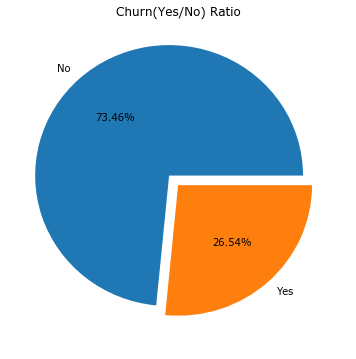

In [18]:
plt.rcParams['figure.figsize']=6,6
plt.pie(customerDf['Churn'].value_counts(),labels=customerDf['Churn'].value_counts().index,autopct='%1.2f%%',explode=(0.1,0))
plt.title('Churn(Yes/No) Ratio')
savePic('Churn(Yes or No) Ratio')
plt.show()

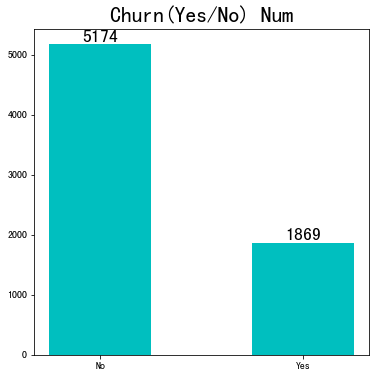

In [19]:
# 使用catplot需要安装seaborn V0.9.0：conda install seaborn==0.9.0
churnDf=customerDf['Churn'].value_counts().to_frame()
x=churnDf.index
y=churnDf['Churn']

plt.bar(x,y,width = 0.5,color = 'c')

#用来正常显示中文标签（需要安装字库）
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams.update({'font.size': 18})
plt.title('Churn(Yes/No) Num')
for a,b in zip(x,y):
    plt.text(a,b+10,'%.0f' % b, ha='center', va= 'bottom')
savePic('Churn(Yes or No) Num')
plt.show()

属于不平衡数据集，流失用户占比达26.54%。

##### 用户基本属性分析：

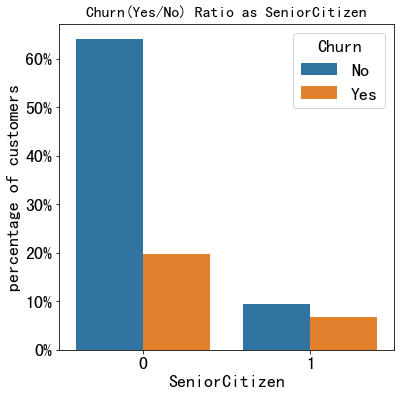

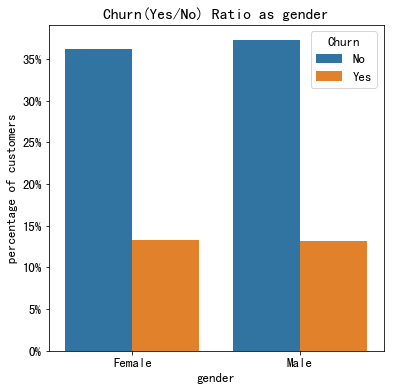

In [20]:
def barplot_percentages(feature,orient='v',axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = (customerDf.groupby(feature)["Churn"].value_counts()/len(customerDf)).to_frame()
    g.rename(columns={"Churn":axis_name},inplace=True)
    g.reset_index(inplace=True)

    #print(g)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
        plt.rcParams.update({'font.size': 13})
        #plt.legend(fontsize=10)
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
        #plt.legend(fontsize=10)
    plt.title('Churn(Yes/No) Ratio as {0}'.format(feature))
    savePic('Churn(Yes or No) Ratio as {0}'.format(feature))
    plt.show()
barplot_percentages("SeniorCitizen")
barplot_percentages("gender")

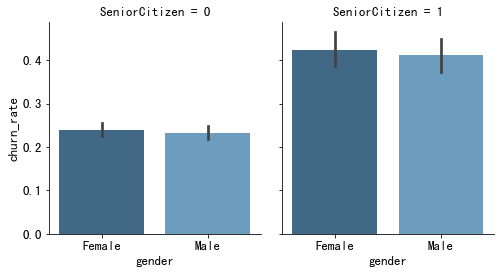

In [21]:
customerDf['churn_rate'] = customerDf['Churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(customerDf, col="SeniorCitizen", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "churn_rate", palette = "Blues_d", order= ['Female', 'Male'])
plt.rcParams.update({'font.size': 13})
savePic('Churn(Yes or No) Ratio as gender and SeniorCitizen')
plt.show()

用户流失与性别基本无关；
年老用户流失占显著高于年轻用户。

In [22]:
#g = sns.FacetGrid(customerDf, row='SeniorCitizen', col="gender", hue="Churn", height=3.5)
#g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.6)
#g.add_legend()
#plt.rcParams.update({'font.size': 15})
#plt.legend(fontsize=10)
#plt.show()

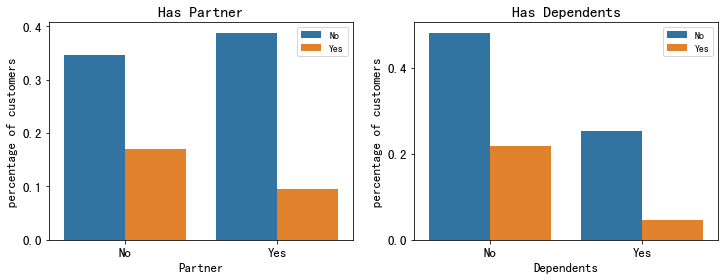

In [23]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has Partner")
axis[1].set_title("Has Dependents")
axis_y = "percentage of customers"

# Plot Partner column
gp_partner = (customerDf.groupby('Partner')["Churn"].value_counts()/len(customerDf)).to_frame()
gp_partner.rename(columns={"Churn": axis_y}, inplace=True)
gp_partner.reset_index(inplace=True)
ax1 = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])
ax1.legend(fontsize=10)
#ax1.set_xlabel('伴侣')


# Plot Dependents column
gp_dep = (customerDf.groupby('Dependents')["Churn"].value_counts()/len(customerDf)).to_frame()
#print(gp_dep)
gp_dep.rename(columns={"Churn": axis_y} , inplace=True)
#print(gp_dep)
gp_dep.reset_index(inplace=True)
#print(gp_dep)

ax2 = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])
#ax2.set_xlabel('家属')


#设置字体大小
plt.rcParams.update({'font.size': 20})
ax2.legend(fontsize=10)

#设置
savePic('Churn(Yes or No) Ratio as partner and dependents')
plt.show()

有伴侣的用户流失占比低于无伴侣用户；
有家属的用户较少；
有家属的用户流失占比低于无家属用户。

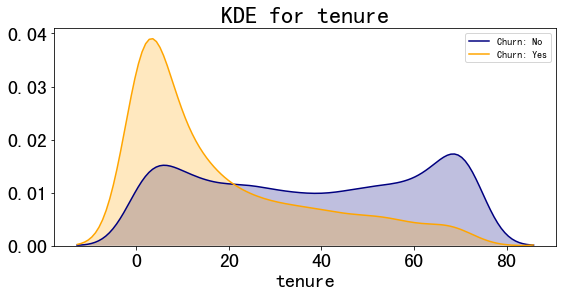

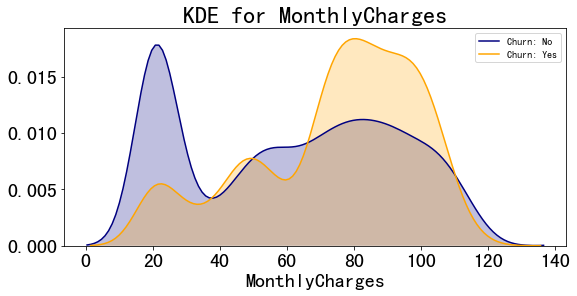

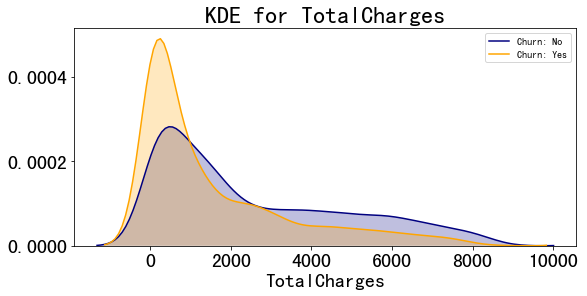

In [24]:
# Kernel density estimaton核密度估计
def kdeplot(feature,xlabel):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {0}".format(feature))
    ax0 = sns.kdeplot(customerDf[customerDf['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No', shade='True')
    ax1 = sns.kdeplot(customerDf[customerDf['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes',shade='True')
    plt.xlabel(xlabel)
    #设置字体大小
    plt.rcParams.update({'font.size': 20})
    plt.legend(fontsize=10)
kdeplot('tenure','tenure')
savePic('Churn(Yes or No) Ratio as tenure kde')
kdeplot('MonthlyCharges','MonthlyCharges')
savePic('Churn(Yes or No) Ratio as MonthlyCharges kde')
kdeplot('TotalCharges','TotalCharges')
savePic('Churn(Yes or No) Ratio as TotalCharges kde')
plt.show()

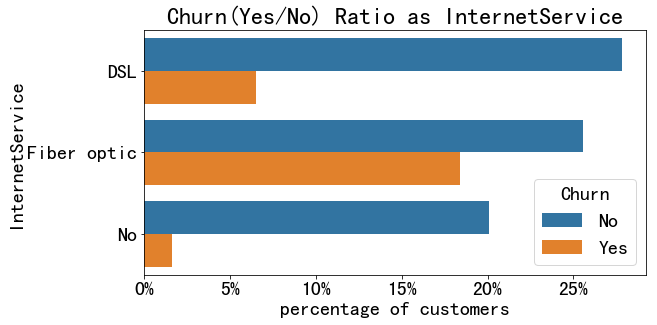

In [25]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("InternetService", orient="h")

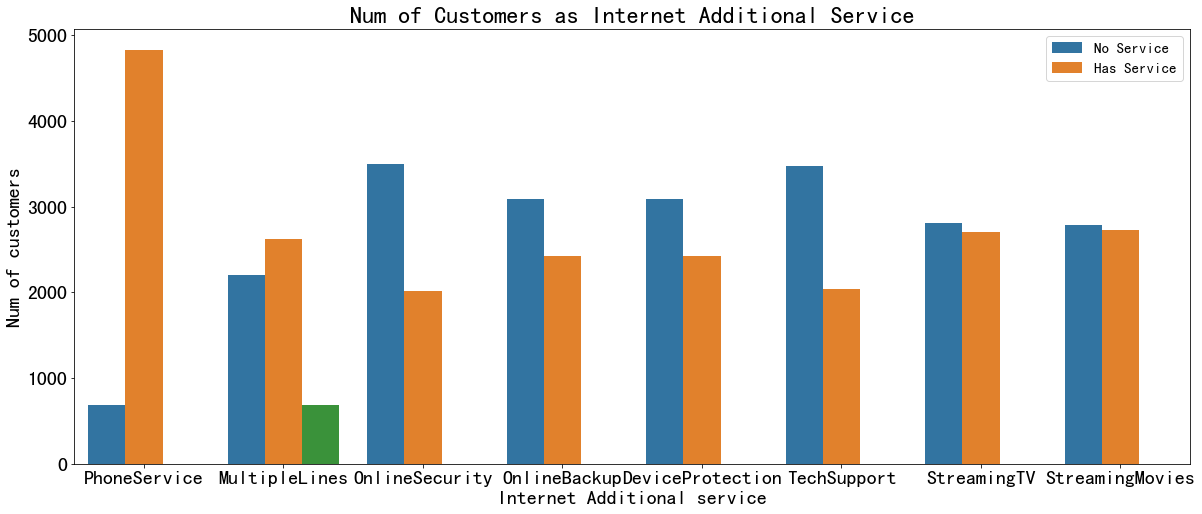

In [26]:
cols = ["PhoneService","MultipleLines","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(customerDf[customerDf["InternetService"] != "No"][cols])
df1.rename(columns={'value': 'Has service'},inplace=True)
plt.figure(figsize=(20, 8))
ax = sns.countplot(data=df1, x='variable', hue='Has service')
ax.set(xlabel='Internet Additional service', ylabel='Num of customers')
plt.rcParams.update({'font.size':20})
plt.legend( labels = ['No Service', 'Has Service'],fontsize=15)
plt.title('Num of Customers as Internet Additional Service')
savePic('Churn(Yes or No) Num as Internet Additional Service')
plt.show()

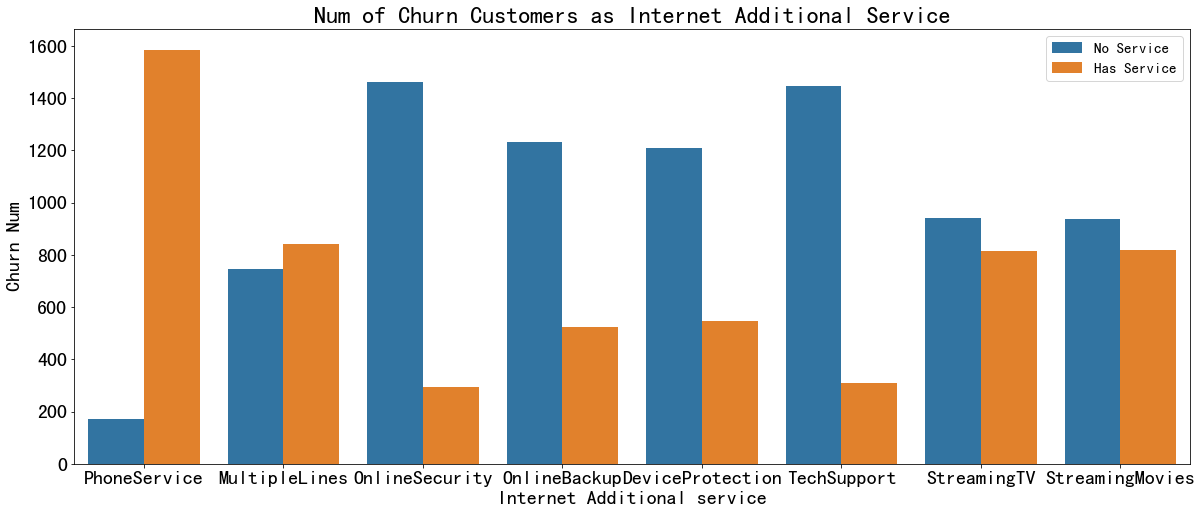

In [27]:
plt.figure(figsize=(20, 8))
df1 = customerDf[(customerDf.InternetService != "No") & (customerDf.Churn == "Yes")]
df1 = pd.melt(df1[cols])
df1.rename(columns={'value': 'Has service'}, inplace=True)
ax = sns.countplot(data=df1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Internet Additional service', ylabel='Churn Num')
plt.rcParams.update({'font.size':20})
plt.legend( labels = ['No Service', 'Has Service'],fontsize=15)
plt.title('Num of Churn Customers as Internet Additional Service')
savePic('Churn Num as Internet Additional Service')
plt.show()

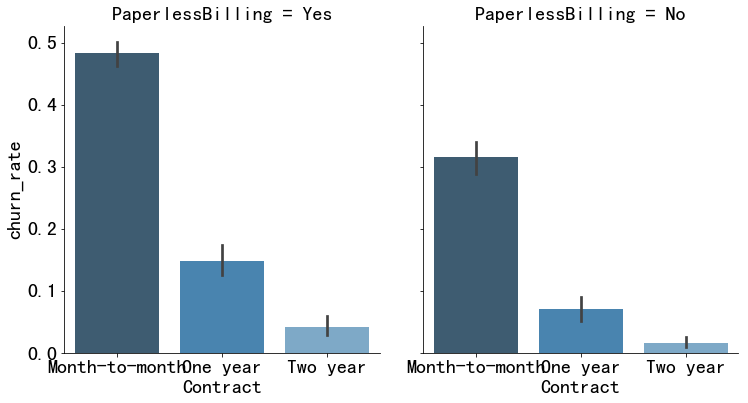

In [28]:
g = sns.FacetGrid(customerDf, col="PaperlessBilling", height=6, aspect=.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette = "Blues_d", order= ['Month-to-month', 'One year', 'Two year'])
plt.rcParams.update({'font.size':18})
savePic('Churn Ratio as PaperlessBilling')
plt.show()

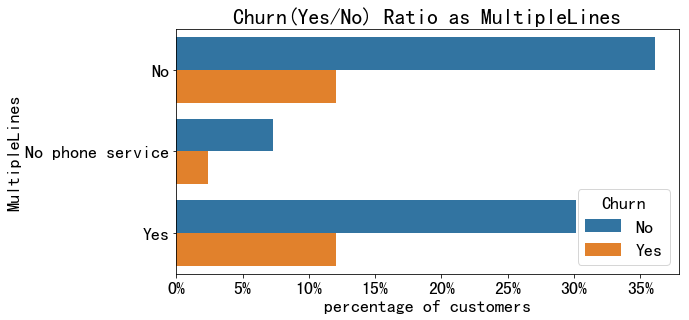

In [29]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("MultipleLines", orient='h')

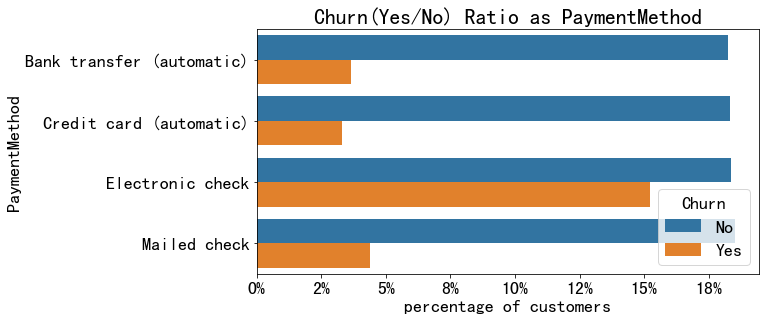

In [30]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod",orient='h')

## 构建预测模型

###### 数据归一化处理

In [31]:
customerDf.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_rate
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1


In [32]:
customerID=customerDf['customerID']
customerDf.drop(['customerID'],axis=1, inplace=True)

In [33]:
cateCols = [c for c in customerDf.columns if customerDf[c].dtype == 'object' or c == 'SeniorCitizen']
dfCate = customerDf[cateCols].copy()
dfCate.head(3)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes


In [34]:
for col in cateCols:
    if dfCate[col].nunique() == 2:
        dfCate[col] = pd.factorize(dfCate[col])[0]
    else:
        dfCate = pd.get_dummies(dfCate, columns=[col])

dfCate.head(3)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1


In [35]:
scaler = StandardScaler(copy=False)
#customerDf[['tenure','MonthlyCharges','TotalCharges']]=scaler.fit_transform(customerDf[['tenure','MonthlyCharges','TotalCharges']])
dfCate['tenure']=customerDf[['tenure']]
dfCate['MonthlyCharges']=customerDf[['MonthlyCharges']]
dfCate['TotalCharges']=customerDf[['TotalCharges']]
dfCate.head(3)
#dfCate=pd.concat([dfCate,customerDf['tenure','MonthlyCharges','TotalCharges']],axis=1)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,29.85,29.85
1,1,0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,34,56.95,1889.50
2,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,2,53.85,108.15


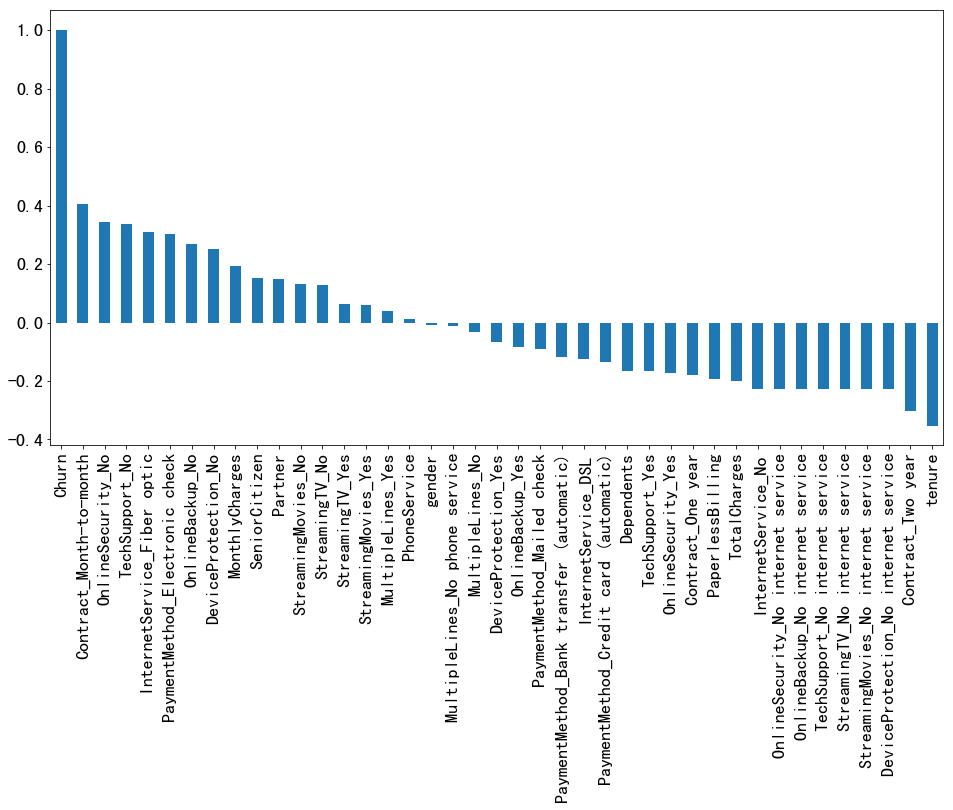

In [36]:
plt.figure(figsize=(16,8))
dfCate.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [37]:
dfCate1=dfCate.copy()

In [38]:
dfCate1.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,29.85,29.85
1,1,0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,34,56.95,1889.50
2,1,0,1,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,2,53.85,108.15
3,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,45,42.30,1840.75
4,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,2,70.70,151.65


In [39]:
dfCate=dfCate1.copy()

In [40]:
# 特征选择，最后一个结果字段（这个是作为标识）
dropFea = ['gender','PhoneService',
           'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
           'DeviceProtection_No internet service', 'TechSupport_No internet service',
           'StreamingTV_No internet service', 'StreamingMovies_No internet service',
           #'OnlineSecurity_No', 'OnlineBackup_No',
           #'DeviceProtection_No','TechSupport_No',
           #'StreamingTV_No', 'StreamingMovies_No',
           ]
dfCate.drop(dropFea, inplace=True, axis =1) 




In [41]:
# 由于没有用作预测的数据集，我们在此选择10个作为

# 最后一列是作为标识
# df=dfCate.loc[0:7032,:]
df=dfCate
target = df['Churn'].values
#列表：特征和1个标识
columns = df.columns.tolist()

In [42]:
plt.figure(figsize=(16,8))
df.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')
#plt.show()

In [43]:
# 列表：特征
columns.remove('Churn')
# 含有特征的DataFrame
features = df[columns].values
# 30% 作为测试集，其余作为训练集
# random_state = 1表示重复试验随机得到的数据集始终不变
# stratify = target 表示按标识的类别，作为训练数据集、测试数据集内部的分配比例
train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.30, stratify = target, random_state = 50)

In [44]:
# 构造各种分类器
classifiers = [
    SVC(random_state = 1, kernel = 'rbf'),    
    DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
    RandomForestClassifier(random_state = 1, criterion = 'gini'),
    KNeighborsClassifier(metric = 'minkowski'),
    AdaBoostClassifier(random_state = 1),   
]
# 分类器名称
classifier_names = [
            'svc', 
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'adaboostclassifier',
]
# 分类器参数
#注意分类器的参数，字典键的格式，GridSearchCV对调优的参数格式是"分类器名"+"__"+"参数名"
classifier_param_grid = [
            {'svc__C':[0.1], 'svc__gamma':[0.01]},
            {'decisiontreeclassifier__max_depth':[6,9,11]},
            {'randomforestclassifier__n_estimators':range(1,11)} ,
            {'kneighborsclassifier__n_neighbors':[4,6,8]},
            {'adaboostclassifier__n_estimators':[70,80,90]}
]

In [45]:
# 对具体的分类器进行 GridSearchCV 参数调优
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score = 'accuracy_score'):
    response = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv=3, scoring = score)
    # 寻找最优的参数 和最优的准确率分数
    search = gridsearch.fit(train_x, train_y)
    print("GridSearch 最优参数：", search.best_params_)
    print("GridSearch 最优分数： %0.4lf" %search.best_score_)
    #采用predict函数（特征是测试数据集）来预测标识，预测使用的参数是上一步得到的最优参数
    predict_y = gridsearch.predict(test_x)
    print(" 准确率 %0.4lf" %accuracy_score(test_y, predict_y))
    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy_score(test_y,predict_y)
    return response
 
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    #采用 StandardScaler 方法对数据规范化：均值为0，方差为1的正态分布
    pipeline = Pipeline([
            #('scaler', StandardScaler()),
            #('pca',PCA),
            (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid , score = 'accuracy')

GridSearch 最优参数： {'svc__C': 0.1, 'svc__gamma': 0.01}
GridSearch 最优分数： 0.7558
 准确率 0.7582
GridSearch 最优参数： {'decisiontreeclassifier__max_depth': 6}
GridSearch 最优分数： 0.7907
 准确率 0.7695
GridSearch 最优参数： {'randomforestclassifier__n_estimators': 10}
GridSearch 最优分数： 0.7830
 准确率 0.7638
GridSearch 最优参数： {'kneighborsclassifier__n_neighbors': 8}
GridSearch 最优分数： 0.7791
 准确率 0.7634
GridSearch 最优参数： {'adaboostclassifier__n_estimators': 80}
GridSearch 最优分数： 0.8039
 准确率 0.7960


##### 实施方案

In [46]:
model =  AdaBoostClassifier(n_estimators=80)
model.fit(train_x,train_y)

# 提取customerID
pred_id = customerID.tail(10)
# 提取预测数据集特征
pred_x = dfCate.drop(['Churn'],axis=1).tail(10)

# 预测值
pred_y = model.predict(pred_x)

# 预测结果
predDf = pd.DataFrame({'customerID':pred_id, 'Churn':pred_y})
print(predDf)

      Churn  customerID
7033      0  9767-FFLEM
7034      0  0639-TSIQW
7035      0  8456-QDAVC
7036      0  7750-EYXWZ
7037      0  2569-WGERO
7038      0  6840-RESVB
7039      0  2234-XADUH
7040      0  4801-JZAZL
7041      1  8361-LTMKD
7042      0  3186-AJIEK
